##VAE

In [ ]:
from tqdm import tqdm
import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

import torchvision
import torchvision.transforms as transforms
import os

import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import save_image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
zip_file = '/content/without.zip'

rootdir=zipfile.ZipFile(zip_file, 'r')
rootdir.extractall()

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

class CustomDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = os.listdir(folder_path)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_name = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(image_name)

        if self.transform:
            image = self.transform(image)

        return image

# Путь к папке с изображениями
folder_path = "/content/archive"

# Преобразования для предварительной обработки изображений
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Создание экземпляра Dataset и DataLoader
custom_dataset = CustomDataset(folder_path, transform=transform)

# Разделение данных на тренировочную и тестовую выборки
train_data, test_data = train_test_split(custom_dataset, test_size=0.2, random_state=42)

batchsize=64

# Создание DataLoader для тренировочной и тестовой выборок
trainloader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
testloader = DataLoader(test_data, batch_size=batchsize, shuffle=False)

dataloader = DataLoader(custom_dataset, batch_size=batchsize, shuffle=True)

In [ ]:
## Template code
## Write your code here
# Convolution formula: ((n + 2p - f) / s) + 1
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        #Encoder part
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1) #256*256*1 -> 128*128*32
        self.bn1=nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1) #128*128*32 -> 64*64*64
        self.bn2=nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) #64*64*64  -> 32*32*128
        self.bn3=nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU(inplace=True)

        self.flatten = nn.Flatten()

        self.mu = nn.Linear(32*32*128, 40)  # 32*32*128
        self.std = nn.Linear(32*32*128, 40)  # 32*32*128

        # Decoder part
        self.fc = nn.Linear(40, 32*32*128)
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.dec_bn1 = nn.BatchNorm2d(64)
        self.dec_relu1 = nn.ReLU(inplace=True)

        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.dec_bn2 = nn.BatchNorm2d(32)
        self.dec_relu2 = nn.ReLU(inplace=True)

        self.deconv3 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)
        self.sigmoid = nn.Sigmoid()

    def reparameterize(self, mu, log_var):
      std = torch.exp(log_var/2)#>=0
      eps = torch.randn_like(std)
      return mu + eps * std


    def forward(self, x):
      #Encoder part
      x = self.relu1(self.bn1(self.conv1(x)))
      x = self.relu2(self.bn2(self.conv2(x)))
      x = self.relu3(self.bn3(self.conv3(x)))
      x = self.flatten(x)
      mu = self.mu(x)
      logvar = self.std(x)

      z = self.reparameterize(mu, logvar)

      #Decoder part
      x = self.fc(z)
      x = x.view(x.size(0), 128, 32, 32)
      x = self.dec_relu1(self.dec_bn1(self.deconv1(x)))
      x = self.dec_relu2(self.dec_bn2(self.deconv2(x)))
      recon_x = self.sigmoid(self.deconv3(x))
      return recon_x, mu, logvar


    def encode(self, x):
      x = self.relu1(self.bn1(self.conv1(x)))
      x = self.relu2(self.bn2(self.conv2(x)))
      x = self.relu3(self.bn3(self.conv3(x)))
      x = self.flatten(x)

      mu = self.fc_mu(x)
      logvar = self.fc_logvar(x)
      return mu, logvar

    def decode(self, z):
      x = self.fc(z)
      x = x.view(x.size(0), 128, 32, 32)
      x = self.dec_relu1(self.dec_bn1(self.deconv1(x)))
      x = self.dec_relu2(self.dec_bn2(self.deconv2(x)))
      recon_x = self.sigmoid(self.deconv3(x))
      return recon_x

vae_model = VAE()
vae_model

VAE(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (mu): Linear(in_features=131072, out_features=40, bias=True)
  (std): Linear(in_features=131072, out_features=40, bias=True)
  (fc): Linear(in_features=40, out_features=131072, bias=True)
  (deconv1): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec_bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:
learning_rate=0.001
optimizer = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)
num_epochs = 100

mse_loss = nn.MSELoss(reduction='sum')

# Start training
for epoch in tqdm(range(num_epochs)):
    total_loss=0
    for i, x in enumerate(trainloader):
        # Forward pass
        optimizer.zero_grad()
        x_reconst, mu, log_var = vae_model(x)

        # Compute reconstruction loss and kl divergence
        reconst_loss = mse_loss(x_reconst, x)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Backprop and optimize
        loss = reconst_loss + kl_div

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if (i+1) % 100 == 0:
          #посмотреть trainset, его нет в Dataloader, который я наджипитила, надо переделать dataloader
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(trainloader), reconst_loss.item(), total_loss / len(trainset)))

    with torch.no_grad():
        # Save the sampled images
        z = torch.randn(batchsize, 40).to(device)
        out = vae_model.decode(z).view(-1, 1, 32, 32)
        save_image(out,'./sampled-{}.png'.format(epoch+1))

        # Save the reconstructed images
        out, _, _ = vae_model(x)
        # print('out', out.shape, '\n')
        # print('x', x.shape)
        x_concat = torch.cat([x.view(-1, 1, 32, 32), out.view(-1, 1, 32, 32)], dim=1)
        save_image(x_concat, './reconst-{}.png'.format(epoch+1))

100%|██████████| 100/100 [56:06<00:00, 33.66s/it]


Implement a function that will generate images using the implemented vae

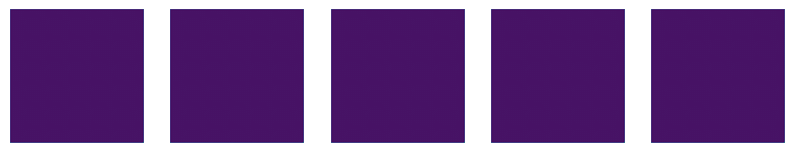

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def generate_images(vae, num_images=5):
    vae.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Generate random latent vectors
        latent_vectors = torch.randn(num_images, 40)

        # Decode latent vectors to generate images
        generated_images = vae.decode(latent_vectors)

    # Plot the generated images
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        image = generated_images[i].permute(1, 2, 0).numpy()
        plt.imshow(np.clip(image, 0, 1))
        plt.axis('off')

    plt.show()

# Assuming 'vae' is the trained VAE model
generate_images(vae_model, num_images=5)